<a href="https://colab.research.google.com/github/tnwls6865/cau_deep_learning/blob/main/Optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Linear Classifier with Regularization

In [ ]:

import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms


In [ ]:
# 데이터 변환 파이프라인 정의: 이미지를 텐서로 변환하고, 각 채널을 0.5로 정규화
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 배치 사이즈 설정
batch_size = 4

# CIFAR10 학습 데이터셋 로드 (이미지 변환 적용)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# 학습 데이터 로더 설정
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# CIFAR10 테스트 데이터셋 로드 (이미지 변환 적용)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# 테스트 데이터 로더 설정
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:04<00:00, 42270830.07it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# CIFAR10 데이터셋의 클래스 정의
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

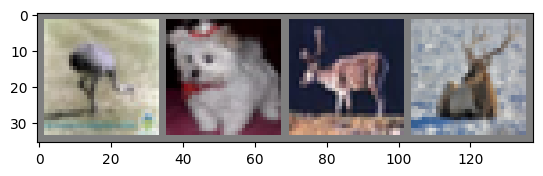

bird  dog   deer  deer 


In [ ]:

# 이미지를 화면에 보여주는 함수 정의 (unnormalize)
def imshow(img):
    img = img / 2 + 0.5     # 정규화된 이미지를 원래 값으로 복원
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # (C, H, W) -> (H, W, C)로 변환하여 표시
    plt.show()


# 랜덤 학습 이미지 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지를 화면에 보여줌
imshow(torchvision.utils.make_grid(images))
# 라벨 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
# 학습 데이터셋과 테스트 데이터셋을 각각 배열로 변환하기 위해 리스트 초기화
X_train, y_train = [], []
X_test, y_test = [], []

# 학습 데이터셋을 이미지 데이터를 numpy 배열로 변환하여 X_train과 y_train에 저장
for i, (X, y) in enumerate(trainset):
    X_train.append(np.array(X))
    y_train.append(np.array(y))

In [ ]:

# 학습 데이터셋 크기 출력
print(len(X_train))
X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape)
print(y_train.shape)

50000
(50000, 3, 32, 32)
(50000,)


In [ ]:

# 테스트 데이터셋을 이미지 데이터를 numpy 배열로 변환하여 X_test와 y_test에 저장
for i, (X, y) in enumerate(testset):
    X_test.append(np.array(X))
    y_test.append(np.array(y))

print(len(X_test))
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_test.shape)
print(y_test.shape)

10000
(10000, 3, 32, 32)
(10000,)


In [ ]:
# 데이터셋을 분할하여 학습, 검증, 테스트 세트로 나눔
num_training = 49000
num_validation = 1000
num_test = 1000

# 검증 데이터 분리
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]
# 학습 데이터 분리
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
# 테스트 데이터 분리
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [ ]:

# 데이터 전처리: 이미지 데이터를 행(row) 형태로 변환
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

print ('Training data shape: ', X_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Test data shape: ', X_test.shape)


Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)


In [ ]:

# 데이터에 편향(bias) 추가 (모든 데이터에 1 추가)
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape)

(49000, 3073) (1000, 3073) (1000, 3073)


In [ ]:
# 선형 분류기 클래스 정의
class LinearClassifier(object):
    def __init__(self):
        self.W = None # 가중치 초기화

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
                batch_size=200, verbose=False):

        num_train, dim = X.shape
        num_classes = np.max(y) + 1  # 클래스의 수를 0 ~ K-1로 가정
        if self.W is None:
            # 가중치 초기화 (랜덤 값으로 초기화)
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # 배치 경사 하강법(Gradient Descent) 실행하여 W 최적화
        loss_history = []
        for it in range(num_iters):
            # 전체 데이터셋에 대해 손실과 그라디언트 계산
            loss, grad = self.loss(X, y, reg)
            loss_history.append(loss)

            # 가중치 업데이트 (Gradient Descent)
            self.W -= learning_rate * grad

            # 손실 값 출력
            if verbose and it % 10 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        # 주어진 데이터 X에 대해 예측 값 반환
        y_pred = np.zeros(X.shape[1])
        y_pred = np.argmax(np.dot(X, self.W), axis=1)

        return y_pred

    def loss(self, W, X_batch, y_batch, reg):

        pass

In [ ]:
def softmax_loss_vectorized(W, X, y, reg):
  # 손실과 기울기 초기화
  N = X.shape[0]
  loss = 0.0
  dW = np.zeros_like(W)

  # 순전파 (forward)
  score = np.dot(X, W)   # (N, C) : X와 W의 행렬 곱을 통해 점수 계산 (N개의 샘플, C개의 클래스)
  out = np.exp(score)    # 점수를 지수 함수로 변환
  out /= np.sum(out, axis=1, keepdims=True)   # (N, C) : 각 샘플에 대해 소프트맥스 확률 계산
  loss -= np.sum(np.log(out[np.arange(N), y]))  # 실제 정답 클래스에 해당하는 소프트맥스 확률의 로그 값을 손실로 더함
  loss /= N  # 데이터 샘플 수로 평균 손실 계산

  loss += 0.5 * reg * np.sum(W**2)  # 가중치에 대한 정규화 항(reg)이 추가된 손실 계산

  # 역전파 (backward)
  dout = np.copy(out)
  dout[np.arange(N), y] -= 1  # 실제 정답 클래스에 해당하는 위치에서 1을 빼줌 (크로스 엔트로피 손실의 기울기)
  dW = np.dot(X.T, dout)
  dW /= N  # 데이터 샘플 수로 평균 기울기 계산

  dW += reg * W  # 기울기에 가중치 정규화 항(reg) 추가

  return loss, dW

In [ ]:
# Softmax 분류기
class Softmax(LinearClassifier):
    """ 다중 클래스 SVM 손실 함수를 사용하는 클래스 """
    def loss(self, X_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)


In [ ]:
# Softmax 분류기 학습
softmax = Softmax()
loss_hist = softmax.train(X_train, y_train.flatten(), learning_rate=1e-5, reg=5e4, num_iters=100, verbose=True)


iteration 0 / 300: loss 758.157154
iteration 10 / 300: loss 2.303254
iteration 20 / 300: loss 2.302533
iteration 30 / 300: loss 2.302533
iteration 40 / 300: loss 2.302533
iteration 50 / 300: loss 2.302533
iteration 60 / 300: loss 2.302533
iteration 70 / 300: loss 2.302533
iteration 80 / 300: loss 2.302533
iteration 90 / 300: loss 2.302533
iteration 100 / 300: loss 2.302533
iteration 110 / 300: loss 2.302533
iteration 120 / 300: loss 2.302533
iteration 130 / 300: loss 2.302533
iteration 140 / 300: loss 2.302533
iteration 150 / 300: loss 2.302533
iteration 160 / 300: loss 2.302533
iteration 170 / 300: loss 2.302533
iteration 180 / 300: loss 2.302533
iteration 190 / 300: loss 2.302533
iteration 200 / 300: loss 2.302533
iteration 210 / 300: loss 2.302533
iteration 220 / 300: loss 2.302533
iteration 230 / 300: loss 2.302533
iteration 240 / 300: loss 2.302533
iteration 250 / 300: loss 2.302533
iteration 260 / 300: loss 2.302533
iteration 270 / 300: loss 2.302533
iteration 280 / 300: loss 2.3

In [ ]:
# 학습 데이터에 대한 예측 정확도 계산
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))

# 검증 데이터에 대한 예측 정확도 계산
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.238449
validation accuracy: 0.249000


## Pytorch를 활용하여 Linear Classifier

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import numpy as np

### 데이터 설정

In [ ]:
# 데이터 변환 파이프라인 정의: 이미지를 텐서로 변환하고, 각 채널을 0.5로 정규화
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 배치 사이즈 설정
batch_size = 4

# CIFAR10 학습 데이터셋 로드 (이미지 변환 적용)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# 학습 데이터 로더 설정
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# CIFAR10 테스트 데이터셋 로드 (이미지 변환 적용)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# 테스트 데이터 로더 설정
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# CIFAR10 데이터셋의 클래스 정의
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

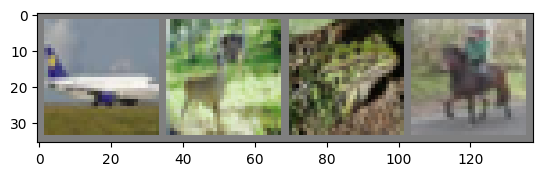

plane deer  frog  horse


In [ ]:
# 이미지를 화면에 보여주는 함수 정의 (unnormalize)
def imshow(img):
    img = img / 2 + 0.5     # 정규화된 이미지를 원래 값으로 복원
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # (C, H, W) -> (H, W, C)로 변환하여 표시
    plt.show()


# 랜덤 학습 이미지 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지를 화면에 보여줌
imshow(torchvision.utils.make_grid(images))
# 라벨 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 모델 정의

In [ ]:
# 간단한 선형 분류기 모델 정의
class LinearClassifier(nn.Module):
    def __init__(self):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(32 * 32 * 3, 10)  # CIFAR-10 이미지 크기 32x32x3, 출력 10 클래스

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # 이미지를 1차원으로 변환
        x = self.linear(x)
        return x

# 모델 초기화
model = LinearClassifier()

### 손실 함수 및 학습률 정의

In [ ]:
# 손실 함수 (Softmax + Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01

### Gradient Descent로 업데이트 하는 학습 함수 정의

In [ ]:
def train_model_with_gradient_descent(num_epochs=10):
    model.train()  # 모델을 학습 모드로 설정
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            # 순전파 (Forward)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 모든 가중치의 기울기(gradient)를 0으로 설정
            model.zero_grad()

            # 역전파 (Backward)
            loss.backward()

            # 수동으로 가중치 업데이트 (Gradient Descent)
            with torch.no_grad():  # autograd를 끄고 수동으로 업데이트
                for param in model.parameters():
                    param -= learning_rate * param.grad  # Gradient Descent 업데이트

            # 손실 출력
            running_loss += loss.item()
            if i % 100 == 99:    # 100 미니배치마다 출력
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}')
                running_loss = 0.0
    print('Finished Training')

In [ ]:
def test_model():
    model.eval()  # 평가 모드 설정
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

In [ ]:
print("Training with Gradient Descent")
train_model_with_gradient_descent(num_epochs=5)
test_model()

Training with Gradient Descent
[Epoch 1, Batch 100] Loss: 2.064
[Epoch 1, Batch 200] Loss: 2.144
[Epoch 1, Batch 300] Loss: 2.130
[Epoch 1, Batch 400] Loss: 2.086
[Epoch 1, Batch 500] Loss: 2.048
[Epoch 1, Batch 600] Loss: 2.141
[Epoch 1, Batch 700] Loss: 2.330
[Epoch 1, Batch 800] Loss: 2.184
[Epoch 1, Batch 900] Loss: 2.048
[Epoch 1, Batch 1000] Loss: 2.194
[Epoch 1, Batch 1100] Loss: 2.169
[Epoch 1, Batch 1200] Loss: 2.164
[Epoch 1, Batch 1300] Loss: 2.064
[Epoch 1, Batch 1400] Loss: 2.184
[Epoch 1, Batch 1500] Loss: 2.174
[Epoch 1, Batch 1600] Loss: 1.950
[Epoch 1, Batch 1700] Loss: 2.076
[Epoch 1, Batch 1800] Loss: 2.124
[Epoch 1, Batch 1900] Loss: 2.162
[Epoch 1, Batch 2000] Loss: 2.157
[Epoch 1, Batch 2100] Loss: 2.220
[Epoch 1, Batch 2200] Loss: 2.113
[Epoch 1, Batch 2300] Loss: 2.173
[Epoch 1, Batch 2400] Loss: 2.167
[Epoch 1, Batch 2500] Loss: 2.242
[Epoch 1, Batch 2600] Loss: 2.271
[Epoch 1, Batch 2700] Loss: 2.111
[Epoch 1, Batch 2800] Loss: 2.036
[Epoch 1, Batch 2900] Loss

### Stochastic Gradient Descent (SGD)
장점: 빠르게 기울기를 계산하고, 큰 데이터셋에서도 효율적입니다.   
단점: 기울기의 노이즈가 커서 손실 함수가 급격하게 진동할 수 있으며, 안정적으로 수렴하는 데 시간이 걸릴 수 있습니다.

In [ ]:

# 배치 사이즈 설정
batch_size = 4

# CIFAR10 학습 데이터셋 로드 (이미지 변환 적용)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# 학습 데이터 로더 설정
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# CIFAR10 테스트 데이터셋 로드 (이미지 변환 적용)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# 테스트 데이터 로더 설정
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [ ]:
# SGD 옵티마이저 설정
optimizer = optim.SGD(model.parameters(), lr=0.01)

### SGD로 업데이트 하는 학습 함수 정의

In [ ]:
def train_model_with_sgd(num_epochs=10):
    model.train()  # 모델을 학습 모드로 설정
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            # 순전파 (Forward)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 모든 가중치의 기울기(gradient)를 0으로 설정
            optimizer.zero_grad()

            # 역전파 (Backward)
            loss.backward()

            # 파라미터 업데이트
            optimizer.step()

            # 손실 출력
            running_loss += loss.item()
            if i % 100 == 99:    # 100 미니배치마다 출력
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}')
                running_loss = 0.0
    print('Finished Training')

### SGD + Momentum
진동 감소와 빠른 수렴이 가능합니다.  
급격한 진동을 억제하고 안정된 학습 진행이 가능합니다.  
평탄한 방향에서의 학습 가속을 할 수 있습니다.  
지역 최솟값에 갇히는 것 방지가 가능합니다.

In [ ]:
# Momentum을 포함한 SGD 설정
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
def train_model_with_momentum(num_epochs=10):
    model.train()  # 모델을 학습 모드로 설정
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            # 순전파 (Forward)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 모든 가중치의 기울기(gradient)를 0으로 설정
            optimizer.zero_grad()

            # 역전파 (Backward)
            loss.backward()

            # 파라미터 업데이트
            optimizer.step()

            # 손실 출력
            running_loss += loss.item()
            if i % 100 == 99:    # 100 미니배치마다 출력
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}')
                running_loss = 0.0
    print('Finished Training')

### Adam Optimizer
장점: 적응형 학습률 덕분에 학습이 더 빠르고, 지역 최솟값에 갇히는 문제를 완화할 수 있음  
 모멘트의 활용으로 기울기 진동을 줄여 안정적인 학습이 가능

단점: 복잡한 최적화 문제에서는 간혹 과적합이나 학습이 불안정할 수 있어, 학습률을 신중히 조정해야 함

In [ ]:
# Adam 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model_with_adam(num_epochs=10):
    model.train()  # 모델을 학습 모드로 설정
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            # 순전파 (Forward)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 모든 가중치의 기울기(gradient)를 0으로 설정
            optimizer.zero_grad()

            # 역전파 (Backward)
            loss.backward()

            # 파라미터 업데이트
            optimizer.step()

            # 손실 출력
            running_loss += loss.item()
            if i % 100 == 99:    # 100 미니배치마다 출력
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}')
                running_loss = 0.0
    print('Finished Training')

### RMSprop Optimizer
장점:기울기가 크거나 작은 방향에서 학습률을 자동으로 조정하므로, 학습이 더 효율적이고 안정적임    
   AdaGrad와 달리 학습이 진행되면서 학습 속도가 지나치게 감소하지 않도록 설계되어 있음

 단점:학습률을 신중하게 설정해야 함
     적절한 학습률을 선택하지 않으면 수렴 속도가 느리거나 학습이 불안정할 수 있음

In [ ]:
# RMSprop 옵티마이저 설정
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

In [ ]:
def train_model_with_rnsprop(num_epochs=10):
    model.train()  # 모델을 학습 모드로 설정
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            # 순전파 (Forward)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 모든 가중치의 기울기(gradient)를 0으로 설정
            optimizer.zero_grad()

            # 역전파 (Backward)
            loss.backward()

            # 파라미터 업데이트
            optimizer.step()

            # 손실 출력
            running_loss += loss.item()
            if i % 100 == 99:    # 100 미니배치마다 출력
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}')
                running_loss = 0.0
    print('Finished Training')

다양한 optimizer에 대해 loss 및 성능 비교

In [ ]:
# 옵티마이저를 생성하는 함수를 정의 (모델을 인자로 받아 새로운 옵티마이저 생성)
def get_optimizer(name, model):
    if name == 'SGD':
        return optim.SGD(model.parameters(), lr=0.01)
    elif name == 'SGD+Momentum':
        return optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif name == 'Adam':
        return optim.Adam(model.parameters(), lr=0.001)
    elif name == 'RMSprop':
        return optim.RMSprop(model.parameters(), lr=0.001)

# 학습 및 테스트 함수 정의
def train_model(optimizer, model, num_epochs=10):
    model.train()  # 학습 모드 설정
    train_loss_history = []
    test_acc_history = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()  # 기울기 초기화
            outputs = model(inputs)  # 순전파
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 가중치 업데이트

            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        train_loss_history.append(avg_loss)

        # 테스트 정확도 평가
        test_acc = test_model(model)
        test_acc_history.append(test_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

    return train_loss_history, test_acc_history

def test_model(model):
    model.eval()  # 평가 모드 설정
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [ ]:
# 옵티마이저 별로 학습 및 테스트 실행
num_epochs = 10
results = {}

optimizer_names = ['SGD', 'SGD+Momentum', 'Adam', 'RMSprop']

for name in optimizer_names:
    print(f'\nTraining with {name} Optimizer')
    model = LinearClassifier()  # 매번 새로운 모델로 초기화
    optimizer = get_optimizer(name, model)  # 옵티마이저를 매번 새로 생성

    train_loss, test_acc = train_model(optimizer, model, num_epochs)
    results[name] = {
        'loss': train_loss,
        'accuracy': test_acc
    }



Training with SGD Optimizer
Epoch [1/10], Loss: 1.8432, Test Accuracy: 38.57%
Epoch [2/10], Loss: 1.7569, Test Accuracy: 39.23%
Epoch [3/10], Loss: 1.7280, Test Accuracy: 39.40%
Epoch [4/10], Loss: 1.7107, Test Accuracy: 40.28%
Epoch [5/10], Loss: 1.7004, Test Accuracy: 39.01%
Epoch [6/10], Loss: 1.6912, Test Accuracy: 40.16%
Epoch [7/10], Loss: 1.6847, Test Accuracy: 40.27%
Epoch [8/10], Loss: 1.6782, Test Accuracy: 38.82%
Epoch [9/10], Loss: 1.6740, Test Accuracy: 40.36%
Epoch [10/10], Loss: 1.6710, Test Accuracy: 39.44%

Training with SGD+Momentum Optimizer
Epoch [1/10], Loss: 1.9762, Test Accuracy: 34.45%
Epoch [2/10], Loss: 1.9068, Test Accuracy: 34.84%
Epoch [3/10], Loss: 1.8891, Test Accuracy: 36.41%
Epoch [4/10], Loss: 1.8832, Test Accuracy: 36.66%
Epoch [5/10], Loss: 1.8705, Test Accuracy: 35.13%
Epoch [6/10], Loss: 1.8653, Test Accuracy: 34.04%
Epoch [7/10], Loss: 1.8739, Test Accuracy: 34.18%
Epoch [8/10], Loss: 1.8509, Test Accuracy: 35.49%
Epoch [9/10], Loss: 1.8473, Test

In [ ]:
# 6. 손실(Loss) 및 정확도(Accuracy) 그래프 출력
plt.figure(figsize=(14, 6))

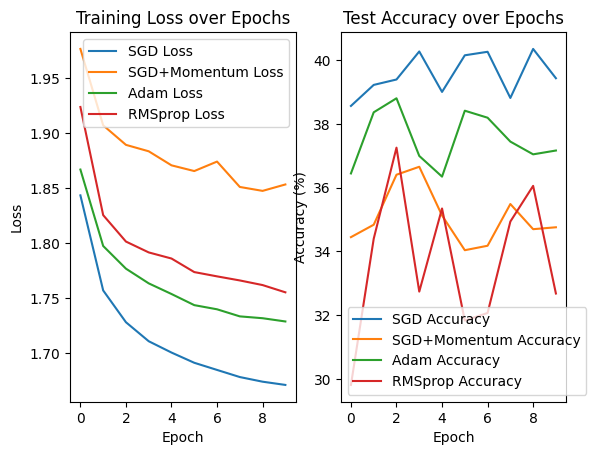

In [ ]:
# Loss 그래프
plt.subplot(1, 2, 1)
for name in results:
    plt.plot(results[name]['loss'], label=f'{name} Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
for name in results:
    plt.plot(results[name]['accuracy'], label=f'{name} Accuracy')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

### GPU 설정

In [ ]:
# 모델 초기화
model = LinearClassifier()

# model.cuda()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
print(device)

cuda


In [ ]:
# 손실 함수 (Softmax + Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
# 최적화 선언
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
def train_model(optimizer, model, num_epochs=10):
    model.train()  # 학습 모드 설정
    train_loss_history = []
    test_acc_history = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # 기울기 초기화
            outputs = model(inputs)  # 순전파
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 가중치 업데이트

            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        train_loss_history.append(avg_loss)

        # 테스트 정확도 평가
        test_acc = test_model(model)
        test_acc_history.append(test_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

    return train_loss_history, test_acc_history

In [ ]:
train_loss, test_acc = train_model(optimizer, model)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
def test_model(model):
    model.eval()  # 평가 모드 설정
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [ ]:
train_loss, test_acc = train_model(optimizer, model)

Epoch [1/10], Loss: 2.1230, Test Accuracy: 33.30%
Epoch [2/10], Loss: 2.0995, Test Accuracy: 33.14%
Epoch [3/10], Loss: 2.0892, Test Accuracy: 32.52%


KeyboardInterrupt: 

### Batch Size

배치 사이즈에 따른 모델 성능을 비교

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# LinearClassifier 정의
class LinearClassifier(nn.Module):
    def __init__(self):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(28 * 28, 10)  # MNIST 이미지 크기 28x28, 출력 10 클래스

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.linear(x)


In [ ]:
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images.cuda())
        loss = criterion(outputs, labels.cuda())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images.cuda())
            loss = criterion(outputs, labels.cuda())
            val_loss += loss.item()

            # 정확도 계산
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.cuda()).sum().item()

    accuracy = 100 * correct / total
    return val_loss / len(val_loader), accuracy


In [ ]:
# 배치 사이즈 및 학습 하이퍼파라미터 설정
batch_sizes = [32, 64, 128, 256]
learning_rate = 0.01
num_epochs = 5

# 성능 결과 저장을 위한 리스트
batch_size_results = {}

# 손실 함수 정의
criterion = nn.CrossEntropyLoss().cuda()

# 각 배치 사이즈에 대해 성능 비교
for batch_size in batch_sizes:
    # 데이터 로더 준비
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    # 모델 초기화 및 옵티마이저 설정
    model = LinearClassifier().cuda()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    print(f"\nBatch Size: {batch_size}")

    for epoch in range(num_epochs):
        train_loss = train_model(model, train_loader, optimizer, criterion)
        val_loss, val_accuracy = validate_model(model, val_loader, criterion)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # 성능 결과 저장
    batch_size_results[batch_size] = val_accuracy


Batch Size: 32
Epoch [1/5] - Train Loss: 0.5061, Validation Loss: 0.3547, Validation Accuracy: 89.87%
Epoch [2/5] - Train Loss: 0.3488, Validation Loss: 0.3154, Validation Accuracy: 91.17%
Epoch [3/5] - Train Loss: 0.3244, Validation Loss: 0.3003, Validation Accuracy: 91.49%
Epoch [4/5] - Train Loss: 0.3122, Validation Loss: 0.2961, Validation Accuracy: 91.74%
Epoch [5/5] - Train Loss: 0.3036, Validation Loss: 0.2898, Validation Accuracy: 91.89%

Batch Size: 64
Epoch [1/5] - Train Loss: 0.6065, Validation Loss: 0.3910, Validation Accuracy: 89.49%
Epoch [2/5] - Train Loss: 0.3863, Validation Loss: 0.3468, Validation Accuracy: 90.30%
Epoch [3/5] - Train Loss: 0.3523, Validation Loss: 0.3261, Validation Accuracy: 90.75%
Epoch [4/5] - Train Loss: 0.3347, Validation Loss: 0.3168, Validation Accuracy: 91.15%
Epoch [5/5] - Train Loss: 0.3232, Validation Loss: 0.3094, Validation Accuracy: 91.31%

Batch Size: 128
Epoch [1/5] - Train Loss: 0.7579, Validation Loss: 0.4680, Validation Accuracy: 8

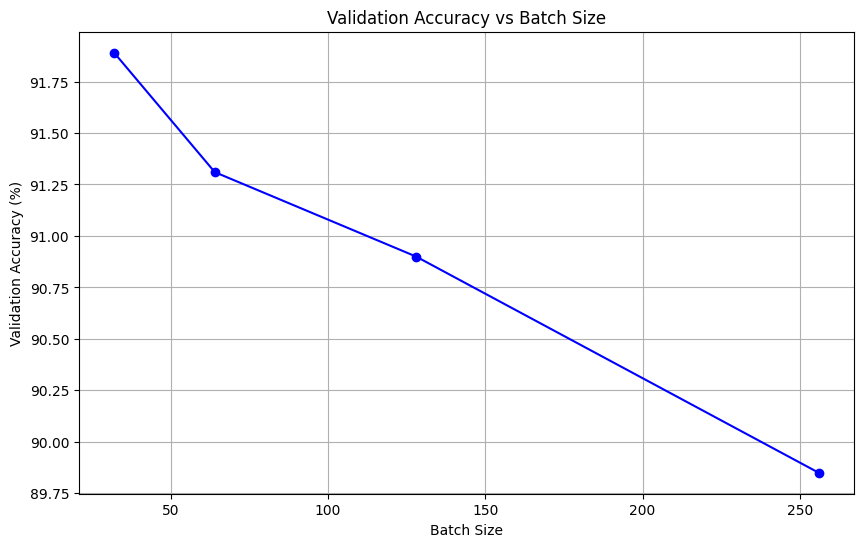

In [ ]:

import matplotlib.pyplot as plt

# 배치 사이즈에 따른 성능 비교 그래프 그리기
plt.figure(figsize=(10, 6))
batch_sizes_list = list(batch_size_results.keys())
accuracies = list(batch_size_results.values())
plt.plot(batch_sizes_list, accuracies, marker='o', linestyle='-', color='b')
plt.title('Validation Accuracy vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy (%)')
plt.grid(True)
plt.show()

### 가중치 초기화 방법

PyTorch에서 사용자 정의 초기화를 적용할 수 있습니다. 일반적인 방법으로는 xavier_uniform_이나 he_normal_ 등이 있으며, 각각 Glorot와 He 초기화를 의미합니다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 간단한 LinearClassifier 정의
class LinearClassifier(nn.Module):
    def __init__(self):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(28 * 28, 10)  # MNIST 이미지 크기 28x28, 출력 10 클래스

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.linear(x)

# 가중치 초기화 함수 (Xavier)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)


In [ ]:
# MNIST 데이터셋 준비
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16383051.15it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 491068.09it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4424267.70it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3156151.22it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# 모델 학습 함수
def train_model(model, optimizer, criterion, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


In [ ]:
# 모델 평가 함수
def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy


In [ ]:
# 초기화 없이 모델 학습
model_no_init = LinearClassifier()
optimizer_no_init = optim.SGD(model_no_init.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

print("Training without initialization:")
train_model(model_no_init, optimizer_no_init, criterion)
print("Evaluating model without initialization:")
accuracy_no_init = evaluate_model(model_no_init)


Training without initialization:
Epoch [1/5], Loss: 0.6084
Epoch [2/5], Loss: 0.3864
Epoch [3/5], Loss: 0.3527
Epoch [4/5], Loss: 0.3354
Epoch [5/5], Loss: 0.3242
Evaluating model without initialization:
Accuracy: 91.36%


In [ ]:
# 초기화 적용 후 모델 학습
model_with_init = LinearClassifier()
model_with_init.apply(init_weights)  # 초기화 적용
optimizer_with_init = optim.SGD(model_with_init.parameters(), lr=0.01)

print("Training with Xavier initialization:")
train_model(model_with_init, optimizer_with_init, criterion)
print("Evaluating model with Xavier initialization:")
accuracy_with_init = evaluate_model(model_with_init)

Training with Xavier initialization:
Epoch [1/5], Loss: 0.6261
Epoch [2/5], Loss: 0.3928
Epoch [3/5], Loss: 0.3567
Epoch [4/5], Loss: 0.3381
Epoch [5/5], Loss: 0.3268
Evaluating model with Xavier initialization:
Accuracy: 91.41%


### 학습률 스케줄링 (Learning Rate Scheduling)
학습률을 동적으로 조정하기 위해 PyTorch의 StepLR 스케줄러를 적용할 수 있습니다.

In [ ]:
# 모델 학습 함수
def train_model_with_scheduler(model, optimizer, scheduler, criterion, num_epochs=5, lr_tracker=None, acc_tracker=None):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # 학습률 기록
        if scheduler is not None:
            scheduler.step()
        if lr_tracker is not None:
            lr_tracker.append(optimizer.param_groups[0]['lr'])

        # 검증 정확도 기록
        if acc_tracker is not None:
            acc = evaluate_model(model)
            acc_tracker.append(acc)

# 모델 평가 함수
def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
# 두 모델을 학습할 학습률 및 정확도 추적 리스트
lr_no_scheduler = []
lr_with_scheduler = []
acc_no_scheduler = []
acc_with_scheduler = []

# 학습률 스케줄러 없이 학습
model_no_scheduler = LinearClassifier()
optimizer_no_scheduler = optim.SGD(model_no_scheduler.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

print("Training without Learning Rate Scheduling:")
train_model_with_scheduler(model_no_scheduler, optimizer_no_scheduler, scheduler=None, criterion=criterion,
                           num_epochs=10, lr_tracker=lr_no_scheduler, acc_tracker=acc_no_scheduler)

# 학습률 스케줄러 적용한 모델 학습 (StepLR 스케줄러 적용)
model_with_scheduler = LinearClassifier()
optimizer_with_scheduler = optim.SGD(model_with_scheduler.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_with_scheduler, step_size=3, gamma=0.1)

print("Training with StepLR Learning Rate Scheduling:")
train_model_with_scheduler(model_with_scheduler, optimizer_with_scheduler, scheduler=scheduler, criterion=criterion,
                           num_epochs=10, lr_tracker=lr_with_scheduler, acc_tracker=acc_with_scheduler)

Training without Learning Rate Scheduling:
Training with StepLR Learning Rate Scheduling:


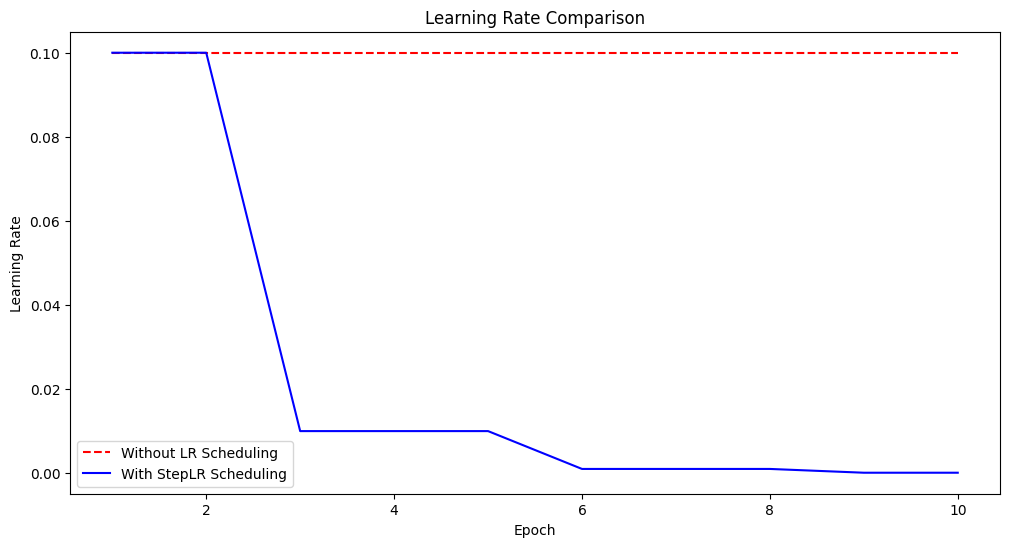

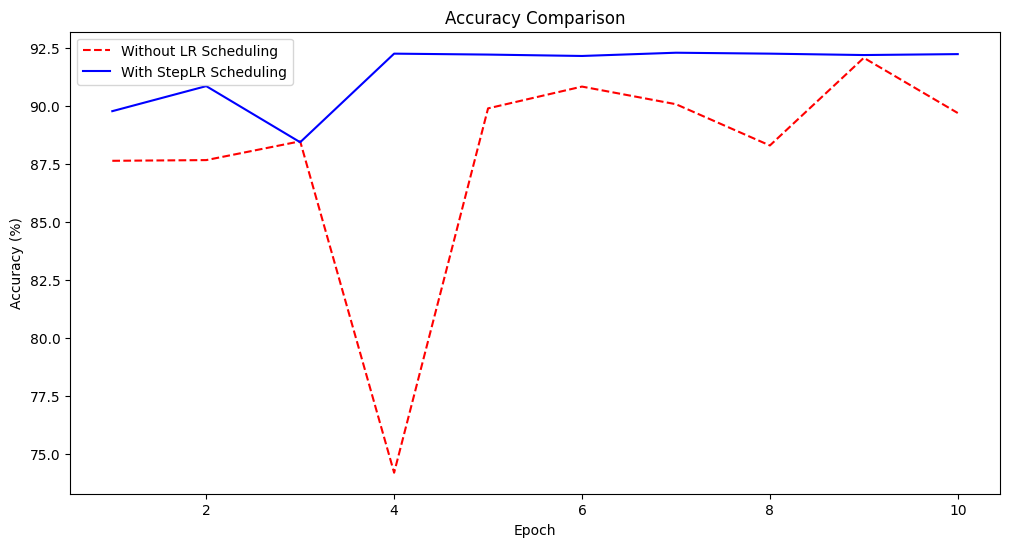

In [ ]:
# 학습률 변화 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(lr_no_scheduler) + 1), lr_no_scheduler, label='Without LR Scheduling', color='red', linestyle='--')
plt.plot(range(1, len(lr_with_scheduler) + 1), lr_with_scheduler, label='With StepLR Scheduling', color='blue', linestyle='-')
plt.title('Learning Rate Comparison')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

# 정확도 변화 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(acc_no_scheduler) + 1), acc_no_scheduler, label='Without LR Scheduling', color='red', linestyle='--')
plt.plot(range(1, len(acc_with_scheduler) + 1), acc_with_scheduler, label='With StepLR Scheduling', color='blue', linestyle='-')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

### 조기 종료 (Early Stopping)
조기 종료를 사용하여 과적합을 방지하고 학습을 효율적으로 멈추는 방법입니다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# LinearClassifier 정의
class LinearClassifier(nn.Module):
    def __init__(self):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(28 * 28, 10)  # MNIST 이미지 크기 28x28, 출력 10 클래스

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # 이미지 차원을 펼침
        return self.linear(x)

# 학습 함수 정의
def train_model(model, train_loader, optimizer, criterion):
    model.train()  # 학습 모드 설정
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()  # 그래디언트 초기화
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트
        running_loss += loss.item()
    return running_loss / len(train_loader)  # 평균 학습 손실 반환

In [ ]:
# 검증 함수 정의
def validate_model(model, val_loader, criterion):
    model.eval()  # 평가 모드 설정
    val_loss = 0.0
    with torch.no_grad():  # 검증 중에는 그래디언트 계산 안함
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(val_loader)  # 평균 검증 손실 반환

In [ ]:
# MNIST 데이터셋 준비
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
val_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

In [ ]:
# EarlyStopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

In [ ]:
# 모델, 손실 함수, 옵티마이저 정의
model = LinearClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# EarlyStopping 인스턴스 생성
early_stopping = EarlyStopping(patience=3)

# 학습 및 검증 손실 추적 리스트
train_losses = []
val_losses = []
stop_epoch = None

# 학습 및 Early Stopping 적용
for epoch in range(20):
    train_loss = train_model(model, train_loader, optimizer, criterion)
    val_loss = validate_model(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    early_stopping(val_loss)

    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        stop_epoch = epoch + 1
        break

Epoch 1, Train Loss: 0.6064, Validation Loss: 0.4014
Epoch 2, Train Loss: 0.3860, Validation Loss: 0.3454
Epoch 3, Train Loss: 0.3521, Validation Loss: 0.3260
Epoch 4, Train Loss: 0.3350, Validation Loss: 0.3173
Epoch 5, Train Loss: 0.3233, Validation Loss: 0.3105
Epoch 6, Train Loss: 0.3158, Validation Loss: 0.3009
Epoch 7, Train Loss: 0.3096, Validation Loss: 0.2956
Epoch 8, Train Loss: 0.3043, Validation Loss: 0.2926
Epoch 9, Train Loss: 0.3009, Validation Loss: 0.2903
Epoch 10, Train Loss: 0.2974, Validation Loss: 0.2887
Epoch 11, Train Loss: 0.2944, Validation Loss: 0.2881
Epoch 12, Train Loss: 0.2923, Validation Loss: 0.2894
Epoch 13, Train Loss: 0.2904, Validation Loss: 0.2858
Epoch 14, Train Loss: 0.2879, Validation Loss: 0.2828
Epoch 15, Train Loss: 0.2861, Validation Loss: 0.2857
Epoch 16, Train Loss: 0.2847, Validation Loss: 0.2784
Epoch 17, Train Loss: 0.2831, Validation Loss: 0.2788
Epoch 18, Train Loss: 0.2819, Validation Loss: 0.2816
Epoch 19, Train Loss: 0.2805, Validat

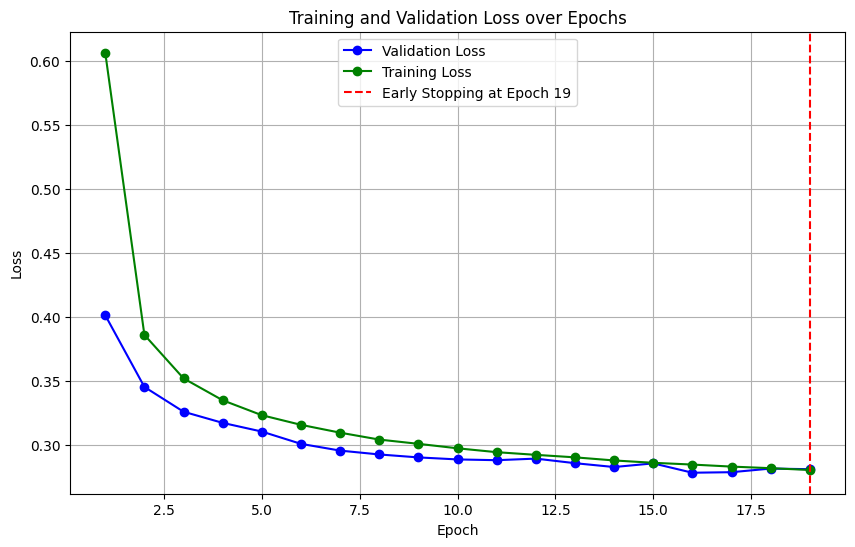

In [ ]:
# 검증 손실 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='blue', marker='o')
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='green', marker='o')

# Early Stopping 발생 지점 표시
if stop_epoch is not None:
    plt.axvline(x=stop_epoch, color='red', linestyle='--', label=f'Early Stopping at Epoch {stop_epoch}')

plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### 하이퍼파라미터 튜닝
학습률, 배치 크기 등 다양한 하이퍼파라미터를 변경해가며 모델 성능을 평가

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [32, 64, 128]
best_accuracy = 0
best_params = {}

# 모델 평가 함수
def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images.cuda())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.cuda()).sum().item()
    accuracy = 100 * correct / total
    return accuracy

for lr in learning_rates:
    for batch_size in batch_sizes:
        # 데이터 로더 준비
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

        # 모델 정의 및 초기화
        model = LinearClassifier().cuda()
        optimizer = optim.SGD(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # 모델 학습
        for epoch in range(10):
            train_model(model, train_loader, optimizer, criterion)
            val_loss = validate_model(model, val_loader, criterion)

        # 모델 성능 평가
        accuracy = evaluate_model(model)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'learning_rate': lr, 'batch_size': batch_size}

print(f'Best accuracy: {best_accuracy:.2f}% with params: {best_params}')

Best accuracy: 92.01% with params: {'learning_rate': 0.01, 'batch_size': 32}


In [ ]:
import seaborn as sns

# 학습 함수 정의
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images.cuda())
        loss = criterion(outputs, labels.cuda())
        loss.backward()
        optimizer.step()

# 검증 함수 정의
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images.cuda())
            val_loss += criterion(outputs, labels.cuda()).item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.cuda()).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# 하이퍼파라미터 목록
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [32, 64, 128]
results = np.zeros((len(learning_rates), len(batch_sizes)))

# 정확도 추적
best_accuracy = 0
best_params = {}

# 하이퍼파라미터에 따른 성능 평가
for i, lr in enumerate(learning_rates):
    for j, batch_size in enumerate(batch_sizes):
        # 데이터 로더 준비
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

        # 모델 정의 및 초기화
        model = LinearClassifier().cuda()
        optimizer = optim.SGD(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # 모델 학습
        for epoch in range(10):
            train_model(model, train_loader, optimizer, criterion)

        # 모델 성능 평가
        accuracy = validate_model(model, val_loader, criterion)
        results[i, j] = accuracy  # 결과 저장

        # 최고 성능 모델 추적
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'learning_rate': lr, 'batch_size': batch_size}

Best accuracy: 92.01% with params: {'learning_rate': 0.01, 'batch_size': 32}


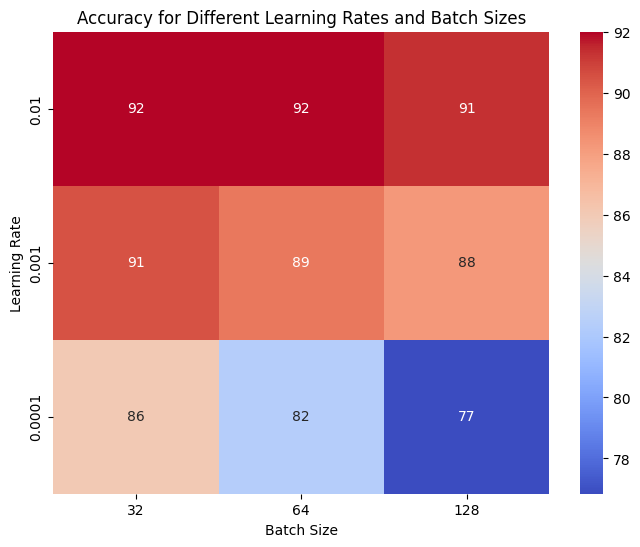

In [ ]:
# 최고 성능 출력
print(f'Best accuracy: {best_accuracy:.2f}% with params: {best_params}')

# 결과를 Heatmap으로 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(results, annot=True, cmap='coolwarm', xticklabels=batch_sizes, yticklabels=learning_rates)
plt.title('Accuracy for Different Learning Rates and Batch Sizes')
plt.xlabel('Batch Size')
plt.ylabel('Learning Rate')
plt.show()

### Seaborn

Seaborn은 Python에서 데이터 시각화를 위한 라이브러리로, 특히 Matplotlib 기반의 고급 통계적 그래프를 쉽게 그릴 수 있도록 설계

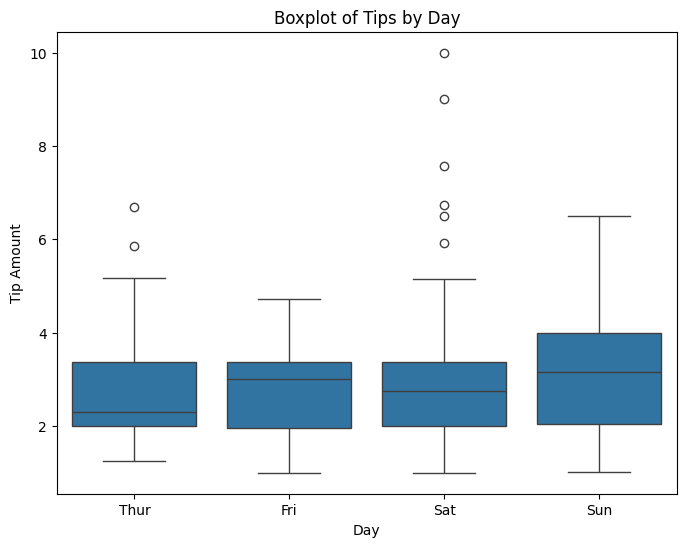

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seaborn의 내장 데이터셋 'tips' 로드
tips = sns.load_dataset("tips")

# 요일별로 팁의 분포를 박스플롯으로 시각화
plt.figure(figsize=(8, 6))
sns.boxplot(x='day', y='tip', data=tips)

# 그래프 제목과 레이블 설정
plt.title('Boxplot of Tips by Day')
plt.xlabel('Day')
plt.ylabel('Tip Amount')

# 그래프 보여주기
plt.show()

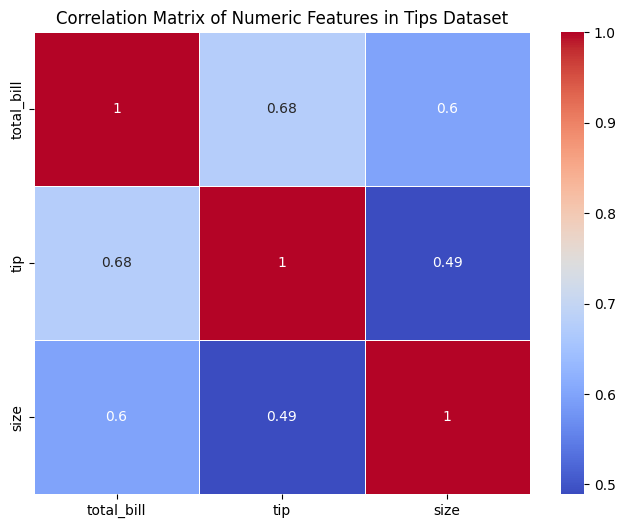

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seaborn의 내장 데이터셋 'tips' 로드
tips = sns.load_dataset("tips")

# 수치형 열만 선택
numeric_tips = tips.select_dtypes(include=['float64', 'int64'])

# 'tips' 데이터의 상관관계 계산
corr_matrix = numeric_tips.corr()

# Heatmap 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# 그래프 제목 설정
plt.title('Correlation Matrix of Numeric Features in Tips Dataset')

# 그래프 보여주기
plt.show()